In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

# M3T3



## Table Of Content:

* [0. Introduction and Dataset Information](#Anaconda)   
* [1. Data Exploration and Feature Engineering](#Libraries)    
* [2. Predicting Building](#Variables) 
* [3. Predicting Floor](#model)
* [4. Predicting Langitude and Latitude](#RvsPython)


# <a class="anchor" id="Anaconda"> 0. Introduction and Dataset Information </a>

***MAIN GOAL***

Application of machine learning techniques to WIFI Locationing, replacing the GPS signal with WAPS signal.

***DATASET***

Two datasets have the same number of variables except for USERID:
Training Dataset: it has 19,937 observation. 
Validation Dataset: it has 1,111 observation.

***INFORMATION***

WAPS: we have 520 different WAPS with signals from -104 to 0.

BUILDINGID: 3 Buildings ( to predict.

FLOOR: BUILDING 1 and BUILDING 2 ( FLOOR from 0 to 3), BUILDING 3 (FLOOR from 0 to 4).

LATITUDE: continous variable.

LONGITUDE:  continous variable.


***RESULTS***

WAPs signal can be good predictors for indoor positioning. 
The best way of predicting ***BUILDING*** is taking into account the WAP with the highest RSSI.

The best way of predicting ***FLOOR*** is taking into account either the WAP with the highest RSSI or all the signals. 

The best way of predicting ***LONGITUDE/LATITUDE*** is taking all signals (strongest and weakest) because this way we are able to predict even remote places.

_____ 
_____    

# <a class="anchor" id="Libraries"> 1. Data Exploration and Feature Engineering </a> 
### Data Exploration and Feature Engineering

The following activities have been carried:
* drop duplicates
* removing low variance row
* balance classes by Floor
* remove low variance columns 
* find the maximum WAP of each observation 
* normalize the data

#### Import libraries 

In [2]:

import sys
import scipy
import numpy as np
import matplotlib
import pandas as pd
import sklearn
import plotly.express as px



from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
import matplotlib.pyplot as plt
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import svm
from numpy import set_printoptions
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import mean_squared_error
from math import sqrt
import statistics
hide_toggle()

#### READING CSV AND CHECKING HEAD/SHAPE/SIZE

In [3]:
training = read_csv('~/Downloads/UJIndoorLoc/trainingData.csv')
validation = read_csv('~/Downloads/UJIndoorLoc/validationData.csv')

#shape #size
#print(training.shape)

# head
#print(training.head(20))

# descriptions
metrics=(training.describe())


#print(training.groupby('BUILDINGID').size())
#print(validation.groupby('BUILDINGID').size())


hide_toggle()

#### DROPPING DUPLICATES

In [4]:
#dropping duplicates 
training = training.drop_duplicates()
hide_toggle()

#### DELETE ROWS WHICH VARIANCE IS ALMOST 0

In [5]:
varianceByRow=training.iloc[:,0:520].var(axis=1)
varianceByRow=varianceByRow[varianceByRow>50]
training=training.loc[varianceByRow.index,:]
metrics=(training.describe())
hide_toggle()

#### SOLVE CLASS BALANCE PROBLEM

Some floors have much more observation compared to others. Hence, we will downsample to uniformally distribute the number of observation for each floor

Number of observation before balancing


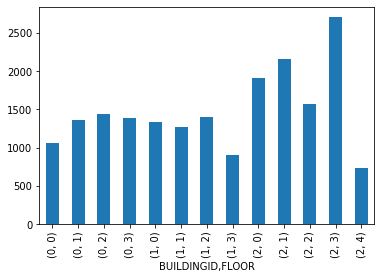

In [6]:
print("Number of observation before balancing")
training.groupby(['BUILDINGID', 'FLOOR']).size().plot(kind='bar') 
hide_toggle()

In [7]:

i_class24 = np.where((training['BUILDINGID']==2) & (training['FLOOR']==4))[0]
n_class24 = np.size(i_class24)


totalIndex =[] 
for i in range(3):
    for j in range(5):
        try:
             i_class00 = np.where((training['BUILDINGID']==i) & (training['FLOOR']==j))[0]
             i_class00_downsampled = np.random.choice(i_class00, size=n_class24, replace=False)
             totalIndex.extend(i_class00_downsampled)
        except:
            pass
           

finalTraining = training.iloc[totalIndex,:]
print("Number of observation after balancing")
print(finalTraining.groupby(['BUILDINGID','FLOOR']).size())

onlyWap=finalTraining.iloc[:,0:520]


onlyInfo=finalTraining.iloc[:,-9:]


finalTraining=pd.concat([onlyWap,onlyInfo],axis=1)
hide_toggle()

Number of observation after balancing
BUILDINGID  FLOOR
0           0        727
            1        727
            2        727
            3        727
1           0        727
            1        727
            2        727
            3        727
2           0        727
            1        727
            2        727
            3        727
            4        727
dtype: int64


#### FIND THE MAXIMUM WAP AND THE MAXIMUM WAP VALUE FOR EACH OBSERVATION

In [8]:

finalTrainingWAP = onlyWap.replace(100,-105) #give value -100 to the 100
finalTrainingWAP['max']= finalTrainingWAP.max(axis=1) # put at the end of the row the maximum wap 
finalTrainingWAP['maxName']= finalTrainingWAP.idxmax(axis=1) #put at the end of the row the name of maximum wap
finalTrainingWAP['Building']=finalTraining['BUILDINGID'] # add building ID
finalTrainingWAP['type']='training' #add training
finalTrainingWAP['Floor']=finalTraining['FLOOR'] #add floor
finalTrainingWAP = finalTrainingWAP.iloc[:,-5:] #select only the last created column
finalTrainingWAP['Longitude']=finalTraining['LONGITUDE']
finalTrainingWAP['Latitude']=finalTraining['LATITUDE']


#value of WAP that are at least maximum once ( i do this only for training)
totalWap= finalTrainingWAP.groupby('maxName')['Building'].nunique()
#select from the tab above only where the WAP are the max of only one
totalWap = totalWap[totalWap.values==1]
#remove from training Wap the WAP that are the maximum in more then one building (by row and by column)
finalTrainingWAP=finalTrainingWAP.loc[finalTrainingWAP['maxName'].isin(totalWap.index)]



validationWAP = validation.iloc[:,0:520] #select only the wap
validationWAP=validationWAP.iloc[:,validationWAP.columns.isin(totalWap.index)] #just use the predictors found in the line 107
validationWAP = validationWAP.replace(100,-105) #replace
validationWAP['max']= validationWAP.max(axis=1) #find the maximum
validationWAP['maxName']= validationWAP.idxmax(axis=1) #name of the maximum
validationWAP['Building']=validation['BUILDINGID'] #add column
validationWAP['type']='validation' #add validation
validationWAP['Floor']=validation['FLOOR'] #add floor
validationWAP['Longitude']=validation['LONGITUDE']
validationWAP['Latitude']=validation['LATITUDE']
validationWAP = validationWAP.iloc[:,-7:]

print("a new table of this kind is created")
print(finalTrainingWAP.head(5))
hide_toggle()

a new table of this kind is created
       max maxName  Building      type  Floor  Longitude      Latitude
18243  -59  WAP075         0  training      0 -7632.2388  4.864988e+06
16316  -53  WAP155         0  training      0 -7646.2446  4.864926e+06
9362   -65  WAP058         0  training      0 -7634.5004  4.864984e+06
15769  -60  WAP053         0  training      0 -7646.3393  4.864932e+06
11194  -55  WAP075         0  training      0 -7637.2257  4.864994e+06


***the above dataset will be used to predict building***

#### Remove Low Variance Columns

Columns which are almost costant would only create noise to the models hence will be deleted. In order to decide which threeshold a columns will be considered "low variance", the standard deviation of the columns will be plotted. In fact, 2 areas can be defined as we can see from the graph below ( histogram of standard deviation of the columns. Clearly the threeshold is where the graphs decays ( around 20 of standard deviation)

***Standard Deviation Distribution before removing low variance columns***

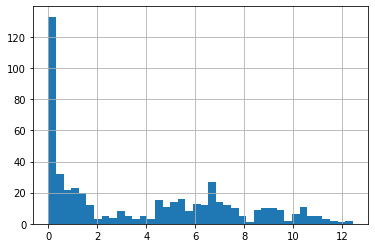

In [9]:

onlyWap=onlyWap.replace(100,-105)



metrics=(onlyWap.describe())
metrics=metrics.transpose()
metrics=metrics[:-9]
metrics['std'].hist(bins=40)
hide_toggle()

***distribution of standard deviation after deleting columns which standandard deviation < 3.5"



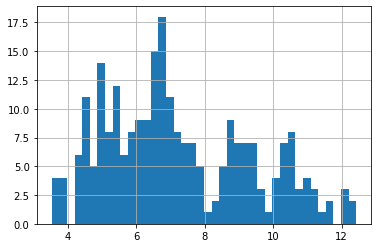

In [10]:

def variance_threshold_select(df, thresh=12):
    df1 = df.copy(deep=True) # Make a deep copy of the dataframe
    selector = VarianceThreshold(thresh)
    selector.fit(df1)
    df2 = df.loc[:,selector.get_support(indices=False)] 

    return df2


onlyWap=variance_threshold_select(onlyWap)
onlyInfo=finalTraining.iloc[:,-9:]


finalTraining=pd.concat([onlyWap,onlyInfo],axis=1)
metrics=(finalTraining.describe())
metrics=metrics.transpose()
metrics=metrics[:-9]
metrics['std'].hist(bins=40)
hide_toggle()

### NORMALIZE THE DATA###

***Data will be normalized over the rows in order to equalize the different difference that each model of phone might have

In [11]:
onlyWap1=onlyWap.copy(deep=True)

minmax_scale = preprocessing.MinMaxScaler().fit(onlyWap1.T)
onlyWap1=minmax_scale.transform(onlyWap1.T).T
onlyWap.loc[:,:]=onlyWap1

perfectWapTraining=pd.concat([onlyWap,onlyInfo],axis=1)

perfectWAPTest=validation.loc[:,validation.columns.isin(perfectWapTraining.columns)]
onlyWAPtest=perfectWAPTest.iloc[:,:-9]
onlyWAPtestInfo=perfectWAPTest.iloc[:,-9:]

onlyWAPtest=onlyWAPtest.replace(100,-105)

minmax_scale = preprocessing.MinMaxScaler().fit(onlyWAPtest.T)
onlyWap1=minmax_scale.transform(onlyWAPtest.T).T

onlyWAPtest.loc[:,:] = onlyWap1

perfectWAPTest=pd.concat([onlyWAPtest,onlyWAPtestInfo],axis=1)

fullDataset = finalTrainingWAP.append(validationWAP)
dummies=pd.get_dummies(fullDataset['maxName'])
fullDataset=pd.concat([fullDataset,dummies], axis=1)


trainingSet = fullDataset.loc[fullDataset.type=='training']
testSet = fullDataset.loc[fullDataset.type=='validation']
print(perfectWapTraining.head(5))
hide_toggle()

       WAP007  WAP008  WAP009  WAP011  WAP012    WAP013    WAP014  WAP015  \
18243     0.0     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0   
16316     0.0     0.0     0.0     0.0     0.0  0.903846  0.884615     0.0   
9362      0.0     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0   
15769     0.0     0.0     0.0     0.0     0.0  0.800000  0.755556     0.0   
11194     0.0     0.0     0.0     0.0     0.0  0.000000  0.000000     0.0   

       WAP016  WAP019  ...  WAP517  LONGITUDE      LATITUDE  FLOOR  \
18243     0.0     0.0  ...     0.0 -7632.2388  4.864988e+06      0   
16316     0.0     0.0  ...     0.0 -7646.2446  4.864926e+06      0   
9362      0.0     0.0  ...     0.0 -7634.5004  4.864984e+06      0   
15769     0.0     0.0  ...     0.0 -7646.3393  4.864932e+06      0   
11194     0.0     0.0  ...     0.0 -7637.2257  4.864994e+06      0   

       BUILDINGID  SPACEID  RELATIVEPOSITION  USERID  PHONEID   TIMESTAMP  
18243           0      134              

***the above dataframe will be used to predict Floor, Latitude and Longitude

# <a class="anchor" id="DataStructures"> 2. Predicting Building </a>  

***Different models have been carried out to predict Building. It's possible to achieve perfect accuracy using the maximum WAP as predictor and Logistic regression as model***   
       
            
 

#### Model using max Wap name

In [12]:
finalArray = trainingSet.values
X = finalArray[:,7:]
y = finalArray[:,2]
y=y.astype('int')


validationArray=testSet.values
X_validation=validationArray[:,7:]
Y_validation=validationArray[:,2]
Y_validation=Y_validation.astype('int')


models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    
	kfold = KFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
 



# Make predictions on validation dataset
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X, y)
predictions = model.predict(X_validation)
predictionReal=model.predict(X)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

hide_toggle()

LR: 0.999892 (0.000325)
KNN: 0.999349 (0.000868)
CART: 0.999457 (0.000875)
NB: 0.999349 (0.000868)
1.0
[[536   0   0]
 [  0 307   0]
 [  0   0 268]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       536
           1       1.00      1.00      1.00       307
           2       1.00      1.00      1.00       268

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111



# <a class="anchor" id="model"> 3. Predicting Floor </a>    

Different models have been carried out to predict Floor. 

*0.90 of accuracy using the max WAP

*0.90 of accuracy using the intensity of each WAP for each Builging

#### Model using max Wap name

In [13]:

y = []
y = finalArray[:,4]
y=y.astype('int')

Y_validation=[]
Y_validation=validationArray[:,4]
Y_validation=Y_validation.astype('int')





models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    
	kfold = KFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

model =  LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X, y)
predictions = model.predict(X_validation)

# Evaluate predictions
print("Accuracy Score")
print(accuracy_score(Y_validation, predictions))
print("Confusion Matrix")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report")
print(classification_report(Y_validation, predictions))


hide_toggle()

LR: 0.907000 (0.008319)
KNN: 0.756807 (0.006433)
CART: 0.907108 (0.008584)
NB: 0.742592 (0.013549)
Accuracy Score
0.8928892889288929
Confusion Matrix
[[119  12   1   0   0]
 [ 20 417  23   2   0]
 [  2  33 253  17   1]
 [  0   0   2 168   2]
 [  0   0   0   4  35]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       132
           1       0.90      0.90      0.90       462
           2       0.91      0.83      0.86       306
           3       0.88      0.98      0.93       172
           4       0.92      0.90      0.91        39

    accuracy                           0.89      1111
   macro avg       0.89      0.90      0.89      1111
weighted avg       0.89      0.89      0.89      1111



#### Model using Wap signals

In [14]:
#%% Floor by WAP

print("This is BUILDING 0 - FLOOR")
perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==0]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==0]



finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-7]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-7]
Y_validation=Y_validation.astype('int')



models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    
	kfold = KFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

model =  KNeighborsClassifier()
model.fit(X, y)
predictions = model.predict(X_validation)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))


floorPredictions=predictions


hide_toggle()


This is BUILDING 0 - FLOOR
LR: 0.983844 (0.007842)
KNN: 0.992096 (0.005760)
CART: 0.963895 (0.011313)
NB: 0.747587 (0.014859)
0.960820895522388
[[ 70   5   3   0]
 [  4 203   1   0]
 [  2   4 159   0]
 [  0   0   2  83]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        78
           1       0.96      0.98      0.97       208
           2       0.96      0.96      0.96       165
           3       1.00      0.98      0.99        85

    accuracy                           0.96       536
   macro avg       0.96      0.95      0.96       536
weighted avg       0.96      0.96      0.96       536



In [15]:

#%% Floor by WAP buidling 1


print("This is BUILDING 1 - FLOOR")

perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==1]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==1]



finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-7]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-7]
Y_validation=Y_validation.astype('int')



models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    
	kfold = KFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

model =  KNeighborsClassifier()
model.fit(X, y)
predictions = model.predict(X_validation)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))





floorPredictions=pd.DataFrame(floorPredictions)
predictions=pd.DataFrame(predictions)
floorPredictions=floorPredictions.append(predictions)

hide_toggle()

This is BUILDING 1 - FLOOR
LR: 0.988996 (0.005056)
KNN: 0.992430 (0.006308)
CART: 0.970422 (0.009393)
NB: 0.741757 (0.016431)
0.8045602605863192
[[ 21   3   6   0]
 [  5 101  36   1]
 [  0   1  80   6]
 [  0   0   2  45]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        30
           1       0.96      0.71      0.81       143
           2       0.65      0.92      0.76        87
           3       0.87      0.96      0.91        47

    accuracy                           0.80       307
   macro avg       0.82      0.82      0.81       307
weighted avg       0.84      0.80      0.81       307



In [16]:

#%% Floor by WAP buidling 2

print("This is BUILDING 2 - FLOOR")


perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==2]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==2]



finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-7]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-7]
Y_validation=Y_validation.astype('int')



models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    
	kfold = KFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

model =  LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X, y)
predictions = model.predict(X_validation)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

predictions=pd.DataFrame(predictions)
floorPredictions=floorPredictions.append(predictions)

hide_toggle()

This is BUILDING 2 - FLOOR
LR: 0.990098 (0.004794)
KNN: 0.994772 (0.003124)
CART: 0.961214 (0.010308)
NB: 0.625582 (0.022436)
0.917910447761194
[[ 22   2   0   0   0]
 [  0 107   4   0   0]
 [  0   4  47   1   2]
 [  0   0   2  35   3]
 [  1   0   0   3  35]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       0.95      0.96      0.96       111
           2       0.89      0.87      0.88        54
           3       0.90      0.88      0.89        40
           4       0.88      0.90      0.89        39

    accuracy                           0.92       268
   macro avg       0.91      0.90      0.91       268
weighted avg       0.92      0.92      0.92       268



# <a class="anchor" id="RvsPython"> 3. Predicting Latitude and Longitude </a>    

#### LONGITUDE

In [17]:

print("Building 0")

perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==0]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==0]




finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-9]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-9]
Y_validation=Y_validation.astype('int')


k_range = [2,3,4,5]
grid_params =  {"n_neighbors": k_range}
gs= GridSearchCV(KNeighborsRegressor(),
                grid_params,
                verbose=1,
                cv=10)
gs_results = gs.fit(X, y)
print("Best score : %f" % gs_results.best_score_)
print("Best parameters: " )
print(gs_results.best_params_)
predictions = gs_results.predict(X_validation)





rmse = sqrt(mean_squared_error(Y_validation, predictions))
print("RMSE :")
print(rmse)


errorTrial=[]
errorTrial= perfectWAPTest1.copy(deep=True)
errorTrial['prediction']=predictions
errorTrial['error']=abs(errorTrial.prediction -errorTrial.LONGITUDE)
errorMetrics=errorTrial.groupby('PHONEID')['error'].agg(['sum','count','mean'])

totalPrediction=perfectWAPTest1.copy(deep=True)
totalPrediction['predictions']=predictions
totalTotal=totalPrediction.copy(deep=True)
hide_toggle()

Building 0
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.0s finished


Best score : 0.976603
Best parameters: 
{'n_neighbors': 3}
RMSE :
6.005111145293639


In [18]:
print("Building 1")
perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==1]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==1]



finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-9]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-9]
Y_validation=Y_validation.astype('int')


k_range = [2,3,4,5,7,8,9,10]


grid_params =  {"n_neighbors": k_range}
gs= GridSearchCV(KNeighborsRegressor(),
                grid_params,
                verbose=1,
                cv=10)
gs_results = gs.fit(X, y)
print("Best score : %f" % gs_results.best_score_)
print("Best parameters: " )
print(gs_results.best_params_)
predictions = gs_results.predict(X_validation)


rmse = sqrt(mean_squared_error(Y_validation, predictions))
print("RMSE :")
print(rmse)




totalPrediction=perfectWAPTest1.copy(deep=True)
totalPrediction['predictions']=predictions
totalTotal=totalTotal.append(totalPrediction)


errorTrial=[]
errorTrial= perfectWAPTest1.copy(deep=True)
errorTrial['prediction']=predictions
errorTrial['error']=abs(errorTrial.prediction -errorTrial.LONGITUDE)
errorMetrics=errorTrial.groupby('PHONEID')['error'].agg(['sum','count','mean'])

hide_toggle()


Building 1
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score : 0.983661
Best parameters: 
{'n_neighbors': 2}
RMSE :
9.385908420231052


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.3s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building 2
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    9.3s finished


Best score : 0.962326
Best parameters: 
{'n_neighbors': 2}
11.693895907375664
Total error on Longitude RMSE:
8.696220598285334
error Distribution Longitude


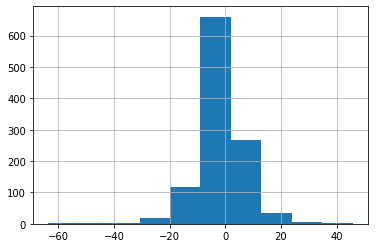

In [19]:
print("Building 2")

perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==2]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==2]



finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-9]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-9]
Y_validation=Y_validation.astype('int')


k_range = [2,3,4,5]
grid_params =  {"n_neighbors": k_range}
gs= GridSearchCV(KNeighborsRegressor(),
                grid_params,
                verbose=1,
                cv=10)
gs_results = gs.fit(X, y)
print("Best score : %f" % gs_results.best_score_)
print("Best parameters: " )
print(gs_results.best_params_)

predictions = gs_results.predict(X_validation)


rmse = sqrt(mean_squared_error(Y_validation, predictions))
print(rmse)

errorTrial=[]
errorTrial= perfectWAPTest1.copy(deep=True)
errorTrial['prediction']=predictions
errorTrial['error']=abs(errorTrial.prediction -errorTrial.LONGITUDE)
#errorTrial.groupby(['PHONEID'])['error'].mean().plot(kind='bar') 
#errorTrial.groupby(['PHONEID'])['error'].sum().plot(kind='bar') 
errorMetrics=errorTrial.groupby('PHONEID')['error'].agg(['sum','count','mean'])

totalPrediction=perfectWAPTest1.copy(deep=True)
totalPrediction['predictions']=predictions
totalTotal=totalTotal.append(totalPrediction)

errorMetrics=errorTrial.groupby('PHONEID')['error'].agg(['sum','count','mean'])

print("Total error on Longitude RMSE:")
rmse = sqrt(mean_squared_error(totalTotal.LONGITUDE, totalTotal.predictions))
print(rmse)


print("error Distribution Longitude")
(totalTotal.LONGITUDE-totalTotal.predictions).hist()

hide_toggle()



### LATITUDE

In [20]:
print("Building 0")

perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==0]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==0]



finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-8]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-8]
Y_validation=Y_validation.astype('int')


k_range = [1,2,3,4,5]
grid_params =  {"n_neighbors": k_range}
gs= GridSearchCV(KNeighborsRegressor(),
                grid_params,
                verbose=1,
                cv=10)
gs_results = gs.fit(X, y)
print("Best score : %f" % gs_results.best_score_)
print("Best parameters: " )
print(gs_results.best_params_)

predictions = gs_results.predict(X_validation)


rmse = sqrt(mean_squared_error(Y_validation, predictions))
print("RMSE_")
print(rmse)

errorTrial=[]
errorTrial= perfectWAPTest1.copy(deep=True)
errorTrial['prediction']=predictions
errorTrial['error']=abs(errorTrial.prediction -errorTrial.LATITUDE)
#errorTrial.groupby(['PHONEID'])['error'].mean().plot(kind='bar') 
#errorTrial.groupby(['PHONEID'])['error'].sum().plot(kind='bar') 


Latitude=predictions
#errorMetrics=errorTrial.groupby('PHONEID')['error'].agg(['sum','count','mean'])

hide_toggle()

Building 0
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score : 0.991214
Best parameters: 
{'n_neighbors': 2}
RMSE_
5.496012801697055


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.9s finished


In [21]:
print("Building 1")


perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==1]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==1]



finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-8]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-8]
Y_validation=Y_validation.astype('int')


k_range = [3,4,5]
grid_params =  {"n_neighbors": k_range}
gs= GridSearchCV(KNeighborsRegressor(),
                grid_params,
                verbose=1,
                cv=10)
gs_results = gs.fit(X, y)
print("Best score : %f" % gs_results.best_score_)
print("Best parameters: " )
print(gs_results.best_params_)

predictions = gs_results.predict(X_validation)


rmse = sqrt(mean_squared_error(Y_validation, predictions))
print("RMSE:")
print(rmse)

predictions=pd.DataFrame(predictions)
Latitude=pd.DataFrame(Latitude)
Latitude00=Latitude.append(predictions)

hide_toggle()

Building 1
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score : 0.980815
Best parameters: 
{'n_neighbors': 3}
RMSE:
10.50286485227113


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.7s finished


In [22]:

# %%Longitude by building (2)
print("Building 2")
perfectWapTraining1=perfectWapTraining[perfectWapTraining.BUILDINGID==2]
perfectWAPTest1=perfectWAPTest[perfectWAPTest.BUILDINGID==2]



finalArray = perfectWapTraining1.values
X = finalArray[:,:-9]
y = finalArray[:,-8]
y=y.astype('int')

validationArray=perfectWAPTest1.values
X_validation=validationArray[:,:-9]
Y_validation=validationArray[:,-8]
Y_validation=Y_validation.astype('int')


k_range = [1,2,3,4,5]
grid_params =  {"n_neighbors": k_range}
gs= GridSearchCV(KNeighborsRegressor(),
                grid_params,
                verbose=1,
                cv=10)
gs_results = gs.fit(X, y)
print("Best score : %f" % gs_results.best_score_)
print("Best parameters: " )
print(gs_results.best_params_)

predictions = gs_results.predict(X_validation)

print("RMSE:")
rmse = sqrt(mean_squared_error(Y_validation, predictions))
print(rmse)

predictions=pd.DataFrame(predictions)

Latitude00=Latitude00.append(predictions)

totalTotal['LatitutePrediction']=Latitude00.values

rmse = sqrt(mean_squared_error(totalTotal.LATITUDE, totalTotal.LatitutePrediction))

print("Total RMSE on Latitude")
print(rmse)

hide_toggle()



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building 2
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.1s finished


Best score : 0.961501
Best parameters: 
{'n_neighbors': 3}
RMSE:
9.854223530691343
Total RMSE on Latitude
8.232770046438462


## RESULTS

***DISTRIBUTION OF THE ERRORS

total error distribution


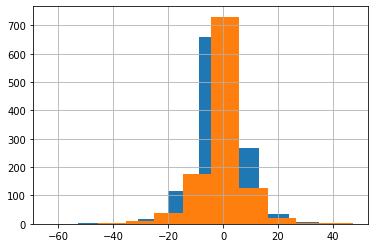

In [38]:
totalTotal['errorLongitude']=(totalTotal.LONGITUDE -totalTotal.predictions)
totalTotal['errorLatitude']=(totalTotal.LATITUDE - totalTotal.LatitutePrediction)
totalTotal['predictionFloor']=floorPredictions.values
totalTotal['errorFloor']=abs(totalTotal.predictionFloor-totalTotal.FLOOR)

print("total error distribution")
totalTotal['errorLongitude'].hist()

totalTotal['errorLatitude'].hist()
hide_toggle()




In [39]:
print("Longitude RMSE:")
rmse = sqrt(mean_squared_error(totalTotal.LONGITUDE, totalTotal.predictions))
print(rmse)

print("LATITUDE RMSE:")
rmse = sqrt(mean_squared_error(totalTotal.LATITUDE, totalTotal.LatitutePrediction))
print(rmse)

print("FLOOR Accuracy:")
print(accuracy_score(totalTotal.FLOOR, totalTotal.predictionFloor))
hide_toggle()




Longitude RMSE:
8.696220598285334
LATITUDE RMSE:
8.232770046438462
FLOOR Accuracy:
0.9072907290729073


Latitude Error Distribution


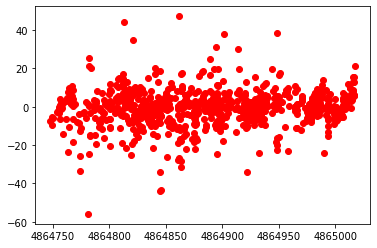

In [40]:
print("Latitude Error Distribution")
plt.plot(totalTotal.LATITUDE,totalTotal.errorLatitude,'ro')
hide_toggle()




Longitude Error Distribution


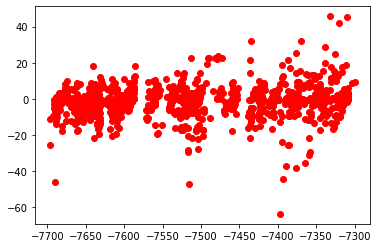

In [41]:
print("Longitude Error Distribution")
plt.plot(totalTotal.LONGITUDE,totalTotal.errorLongitude,'ro')

hide_toggle()


